<a href="https://colab.research.google.com/github/adhamhelmy/llm-fine-tuning/blob/main/strategy_backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install backtrader
!pip install alpaca_trade_api
!pip install matplotlib==3.2.2
!pip install plotly

In [2]:
from google.colab import userdata

API_KEY = userdata.get('ALPACA_API_KEY_ID')
SECRET_KEY = userdata.get('ALPACA_API_SECRET_KEY')

In [3]:
from alpaca_trade_api.rest import REST, TimeFrame
from alpaca_trade_api.stream import Stream

rest_api = REST(API_KEY, SECRET_KEY, 'https://paper-api.alpaca.markets')

In [4]:
# retrieve daily bar data for SPY in a dataframe
spy_bars = rest_api.get_bars('SPY', TimeFrame.Day, '2021-01-01', '2021-03-30').df
spy_bars.head(3)

# quote and trade data also available for equities
# spy_quotes = rest_api.get_quotes('SPY', '2021-01-01', '2021-01-05').df
# spy_trades = rest_api.get_trades('SPY', '2021-01-01', '2021-01-05').df

,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2021-01-04 05:00:00+00:00,368.97,375.45,364.82,623066,375.31,111804895,368.825587
2021-01-05 05:00:00+00:00,371.40,372.50,368.05,338929,368.10,67456696,370.677822
2021-01-06 05:00:00+00:00,373.41,376.98,369.12,575346,369.71,109080743,374.174540


In [7]:
# plotly imports
import plotly.graph_objects as go
import plotly.express as px

# SPY bar data candlestick plot
candlestick_fig = go.Figure(data=[go.Candlestick(x=spy_bars.index,
                open=spy_bars['open'],
                high=spy_bars['high'],
                low=spy_bars['low'],
                close=spy_bars['close'])])

# calculating 5 day SMA using pandas rolling mean
sma = spy_bars['close'].rolling(5).mean().dropna()

# creating a line plot for our sma
sma_fig = px.line(x=sma.index, y=sma)

# adding both plots onto one chart
fig = go.Figure(data=candlestick_fig.data + sma_fig.data)

# displaying our chart
fig.show()

In [8]:
import backtrader as bt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 140 # chart resolution

def run_backtest(strategy, symbols, start, end, timeframe=TimeFrame.Day, cash=10000):
    '''params:
        strategy: the strategy you wish to backtest, an instance of backtrader.Strategy
        symbols: the symbol (str) or list of symbols List[str] you wish to backtest on
        start: start date of backtest in format 'YYYY-MM-DD'
        end: end date of backtest in format: 'YYYY-MM-DD'
        timeframe: the timeframe the strategy trades on (size of bars) -
                   1 min: TimeFrame.Minute, 1 day: TimeFrame.Day, 5 min: TimeFrame(5, TimeFrameUnit.Minute)
        cash: the starting cash of backtest
    '''

    # initialize backtrader broker
    cerebro = bt.Cerebro(stdstats=True)
    cerebro.broker.setcash(cash)

    # add strategy
    cerebro.addstrategy(strategy)

    # add analytics
    # cerebro.addobserver(bt.observers.Value)
    # cerebro.addobserver(bt.observers.BuySell)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='mysharpe')

    # historical data request
    if type(symbols) == str:
        symbol = symbols
        alpaca_data = rest_api.get_bars(symbol, timeframe, start, end,  adjustment='all').df
        data = bt.feeds.PandasData(dataname=alpaca_data, name=symbol)
        cerebro.adddata(data)
    elif type(symbols) == list or type(symbols) == set:
        for symbol in symbols:
            alpaca_data = rest_api.get_bars(symbol, timeframe, start, end, adjustment='all').df
            data = bt.feeds.PandasData(dataname=alpaca_data, name=symbol)
            cerebro.adddata(data)

    # run
    initial_portfolio_value = cerebro.broker.getvalue()
    print(f'Starting Portfolio Value: {initial_portfolio_value}')
    results = cerebro.run()
    final_portfolio_value = cerebro.broker.getvalue()
    print(f'Final Portfolio Value: {final_portfolio_value} ---> Return: {(final_portfolio_value/initial_portfolio_value - 1)*100}%')

    strat = results[0]
    print('Sharpe Ratio:', strat.analyzers.mysharpe.get_analysis()['sharperatio'])
    cerebro.plot(iplot= False)

Starting Portfolio Value: 10000
Final Portfolio Value: 10068.660000000002 ---> Return: 0.6866000000000261%
Sharpe Ratio: -5.323470713347245


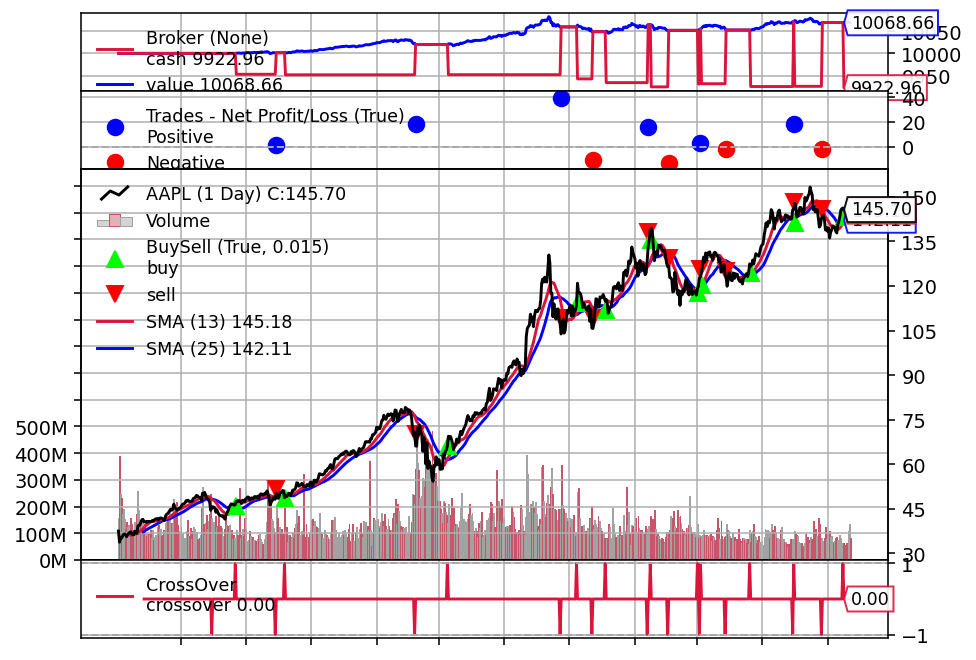

In [9]:
class SmaCross(bt.Strategy):
  # list of parameters which are configurable for the strategy
    params = dict(
        pfast=13,  # period for the fast moving average
        pslow=25   # period for the slow moving average
    )

    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
        sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal

    def next(self):
        if not self.position and self.crossover > 0:  # not in the market
            self.buy()
        elif self.position and self.crossover < 0:  # in the market & cross to the downside
            self.close()  # close long position


run_backtest(SmaCross, 'AAPL', '2019-01-01', '2021-11-01', TimeFrame.Day, 10000)

Starting Portfolio Value: 10000
Final Portfolio Value: 16912.069999999996 ---> Return: 69.12069999999997%
Sharpe Ratio: 1.1860282926578467


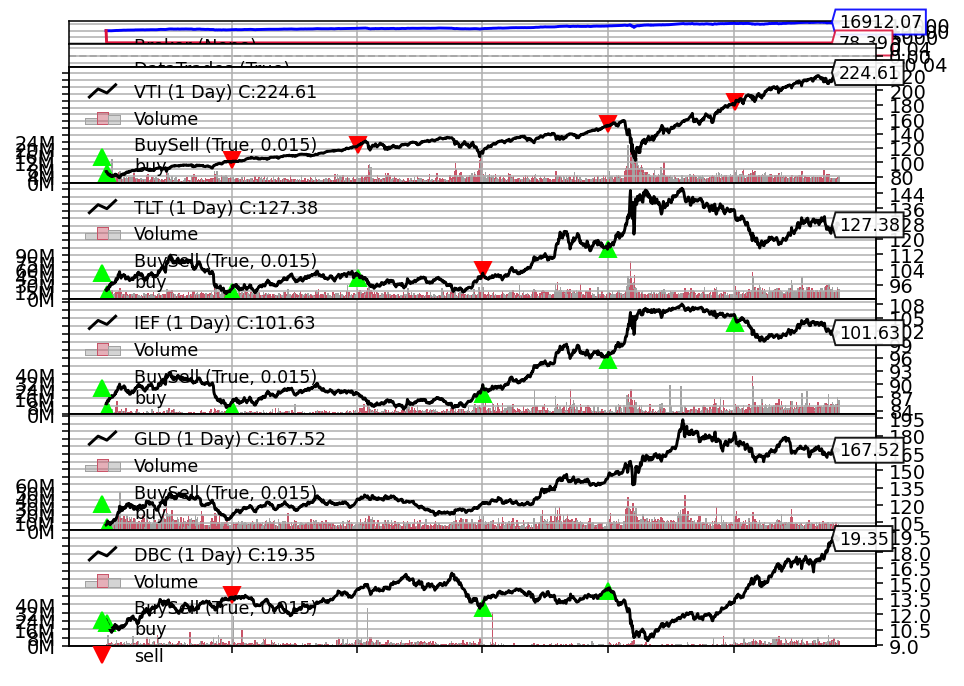

In [10]:
class AllWeatherStrategy(bt.Strategy):

    def __init__(self):
        # the last year we rebalanced (initialized to -1)
        self.year_last_rebalanced = -1
        self.weights = { "VTI" : 0.30 , "TLT" : 0.40, "IEF": 0.15, "GLD" : 0.075, "DBC" : 0.075 }

    def next(self):
        # if we’ve already rebalanced this year
        if self.datetime.date().year == self.year_last_rebalanced:
            return

        # update year last balanced
        self.year_last_rebalanced = self.datetime.date().year

        # enumerate through each security
        for i,d in enumerate(self.datas):
            # rebalance portfolio with desired target percents
            symbol = d._name
            self.order_target_percent(d, target=self.weights[symbol])

run_backtest(AllWeatherStrategy, ["VTI", "TLT", "IEF", "GLD", "DBC"] , '2015-01-01', '2021-11-01', TimeFrame.Day, 10000)